# Prediction of immunotherapy response

# Table of contents

0. [Reading dataset](#0-reading-dataset)
1. [Classic classifier](#1-classic-classifier)
2. [GCN classifier](#2-gnn-classifier)
3. [Compare models](#3-compare-models)

In [1]:
import pandas as pd
import numpy as np

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.BinaryClassifierTrainTestManager import BinaryClassifierTrainTestManager
from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager

from models.BinaryClassifier import BinaryClassifier
from models.GCNClassifier import GCNClassifier

from utils.preProcessing import preProcessing

from sklearn.linear_model import LogisticRegression

## 0. Reading dataset and preprocessing

In [2]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]

df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


In [3]:
# Select and normalize features
features_name = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]
X = df.loc[:,features_name].to_numpy()
X = preProcessing.normalize_data(X)

# Numerize label
label_name = "Clinical benefit"
y = np.where(df[label_name]=="DCB",1,0)

## 1. Classic classifier
We use a logistic regression classifier.

In [4]:
# Instanciate classifier
classic_clf = BinaryClassifier(LogisticRegression())

### Make the leave one out cross validation

In [5]:
# Instanciate the train-test manager
classic_manager = BinaryClassifierTrainTestManager(classic_clf)

# Make the leave one out cross validation
test_classes_classic, test_scores_classic = classic_clf.leave_one_out_cross_validation(X, y)

## 2. GCN classifier

In [6]:
# Instanciate the GCN classifier
gcn_classifier = GCNClassifier(len(features_name))

# Instanciate the GCN train test manager
gcn_manager = GCNClassifierTrainTestManager(gcn_classifier)

### Make the leave one out cross validation

In [7]:
# Group labels for connecting patients (tumour type)
group = df["Tumour type"].to_numpy()

test_scores_gcn, test_classes_gcn = gcn_manager.leave_one_out_cross_validation(X, y, group, 10)

## 3. Compare models

In [9]:
## Classic classifier
acc_classic, pre_classic, rec_classic, f1_classic = ClassificationMetrics.eval_metrics_from_conf_matrix(y, test_classes_classic)
fpr_classic, tpr_classic, thresholds_classic = ClassificationMetrics.compute_roc_curve(y, test_scores_classic)
auc_classic = ClassificationMetrics.compute_auc(y, test_scores_classic)

## GCN classifier
acc_gcn, pre_gcn, rec_gcn, f1_gcn = ClassificationMetrics.eval_metrics_from_conf_matrix(y, test_classes_gcn)
fpr_gcn, tpr_gcn, thresholds_gcn = ClassificationMetrics.compute_roc_curve(y, test_scores_gcn)
auc_gcn = ClassificationMetrics.compute_auc(y, test_scores_gcn)

In [10]:
# Classic :
print("Classic classifier : ")
print(f"Accuracy : {acc_classic}")
print(f"Precision : {pre_classic}")
print(f"Recall : {rec_classic}")
print(f"F1-score : {f1_classic}\n")

# GCN :
print("GCN classifier : ")
print(f"Accuracy : {acc_gcn}")
print(f"Precision : {pre_gcn}")
print(f"Recall : {rec_gcn}")
print(f"F1-score : {f1_gcn}")

Classic classifier : 
Accuracy : 0.8
Precision : 0.57
Recall : 0.24
F1-score : 0.33

GCN classifier : 
Accuracy : 0.77
Precision : 0.33
Recall : 0.12
F1-score : 0.17


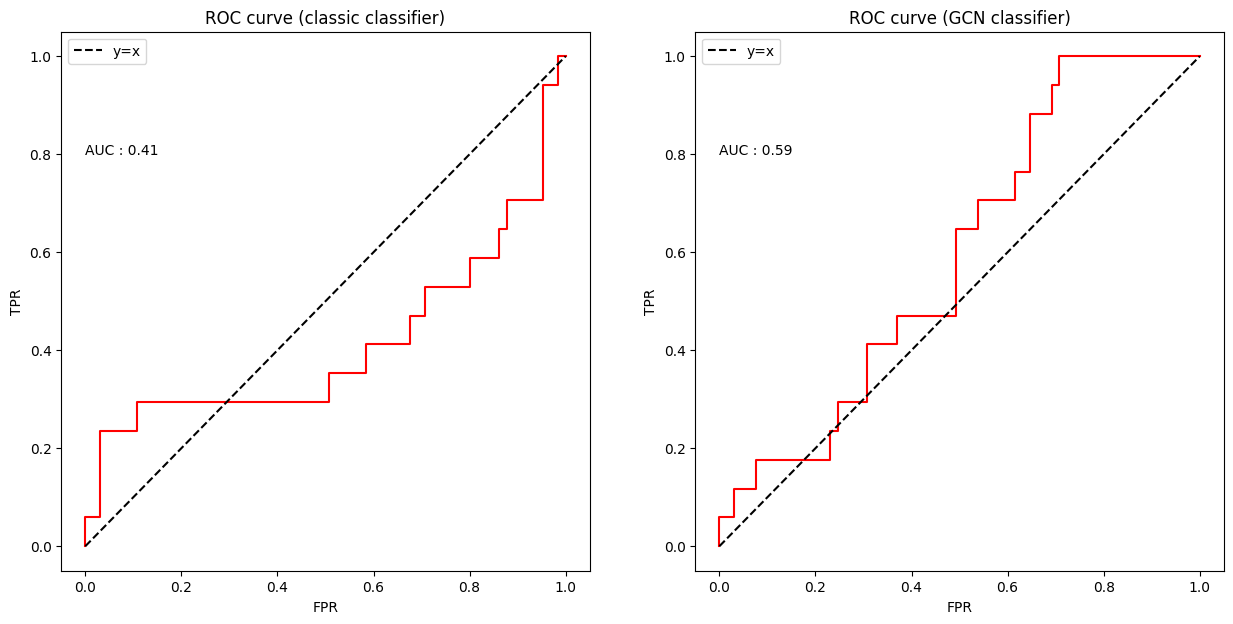

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,7))
x = np.linspace(0,1,100)

# Classic :
ax[0].plot(fpr_classic, tpr_classic, color='red')
ax[0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curve (classic classifier)')
ax[0].legend()
ax[0].text(0,0.8,f"AUC : {auc_classic}")

# GCN :
ax[1].plot(fpr_gcn, tpr_gcn, color='red')
ax[1].plot(x,x,linestyle='--',color='black',label='y=x')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
ax[1].set_title('ROC curve (GCN classifier)')
ax[1].legend()
ax[1].text(0,0.8,f"AUC : {auc_gcn}")

plt.savefig("Response.png")